In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Calculate time difference in minutes between GLCTIMER and STARTTIME
df['time_diff'] = (df['GLCTIMER'] - df['STARTTIME']).dt.total_seconds() / 60.0

# Drop rows with NaN values in 'time_diff'
df = df.dropna(subset=['time_diff'])

# Feature engineering
df['INPUT_length'] = df['INPUT'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df['hour_of_day'] = df['GLCTIMER'].dt.hour
df['day_of_week'] = df['GLCTIMER'].dt.dayofweek
df['rolling_mean'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_std'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

# Selecting important features for prediction
features = df[['time_diff', 'INPUT', 'INPUT_HRS', 'hour_of_day', 'day_of_week', 'rolling_mean', 'rolling_std']]
labels = df['GLC']

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Reshape data for GRU
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the GRU model
model_gru = Sequential([
    GRU(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Use an optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the model with more epochs
history_gru = model_gru.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predictions
gru_predictions = model_gru.predict(X_test_reshaped).flatten()

# Evaluation
mae_gru = mean_absolute_error(y_test, gru_predictions)
mse_gru = mean_squared_error(y_test, gru_predictions)
rmse_gru = mean_squared_error(y_test, gru_predictions, squared=False)
r2_gru = r2_score(y_test, gru_predictions)
mape_gru = mean_absolute_percentage_error(y_test, gru_predictions)

print("=== Performance du modèle GRU ===")
print(f"Mean Absolute Error: {mae_gru}")
print(f"Mean Squared Error: {mse_gru}")
print(f"Root Mean Squared Error: {rmse_gru}")
print(f"R-squared: {r2_gru}")
print(f"Mean Absolute Percentage Error: {mape_gru}")




Epoch 1/50
12076/12076 [==============================] - 109s 8ms/step - loss: 2670.8311 - val_loss: 595.0214
Epoch 2/50
12076/12076 [==============================] - 92s 8ms/step - loss: 689.9156 - val_loss: 516.3447
Epoch 3/50
12076/12076 [==============================] - 90s 7ms/step - loss: 637.0894 - val_loss: 495.7732
Epoch 4/50
12076/12076 [==============================] - 90s 7ms/step - loss: 619.2382 - val_loss: 485.0638
Epoch 5/50
12076/12076 [==============================] - 87s 7ms/step - loss: 605.7840 - val_loss: 488.5766
Epoch 6/50
12076/12076 [==============================] - 91s 8ms/step - loss: 600.4722 - val_loss: 475.7098
Epoch 7/50
12076/12076 [==============================] - 93s 8ms/step - loss: 592.3678 - val_loss: 473.4378
Epoch 8/50
12076/12076 [==============================] - 91s 8ms/step - loss: 584.0783 - val_loss: 472.3169
Epoch 9/50
12076/12076 [==============================] - 89s 7ms/step - loss: 576.8385 - val_loss: 465.0547
Epoch 10/50
12076

In [ ]:
from sklearn.linear_model import LinearRegression

# Définir le modèle de régression linéaire
model_lr = LinearRegression()

# Entraîner le modèle de régression linéaire
model_lr.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
lr_predictions = model_lr.predict(X_test)

# Calculer les métriques d'évaluation
mae_lr = mean_absolute_error(y_test, lr_predictions)
mse_lr = mean_squared_error(y_test, lr_predictions)
rmse_lr = mean_squared_error(y_test, lr_predictions, squared=False)
r2_lr = r2_score(y_test, lr_predictions)
mape_lr = mean_absolute_percentage_error(y_test, lr_predictions)

print("=== Performance du modèle de régression linéaire ===")
print(f"Mean Absolute Error: {mae_lr}")
print(f"Mean Squared Error: {mse_lr}")
print(f"Root Mean Squared Error: {rmse_lr}")
print(f"R-squared: {r2_lr}")
print(f"Mean Absolute Percentage Error: {mape_lr}")


=== Performance du modèle de régression linéaire ===
Mean Absolute Error: 18.826812037555
Mean Squared Error: 935.6477753250851
Root Mean Squared Error: 30.588360128079522
R-squared: 0.6620723378825251
Mean Absolute Percentage Error: 0.1285616805206061


In [ ]:
from sklearn.metrics import classification_report

# Binariser les prédictions et les étiquettes (par exemple, pour les valeurs de glucose)
threshold = 150  # Définir un seuil pour considérer un événement hyperglycémique

# Binariser les prédictions et les étiquettes
lr_predictions_binary = (lr_predictions > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Afficher le rapport de classification
print("Rapport de Classification pour le modèle de régression linéaire :")
print(classification_report(y_test_binary, lr_predictions_binary))


Rapport de Classification pour le modèle de régression linéaire :
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     87242
           1       0.64      0.79      0.71     33511

    accuracy                           0.82    120753
   macro avg       0.78      0.81      0.79    120753
weighted avg       0.84      0.82      0.82    120753



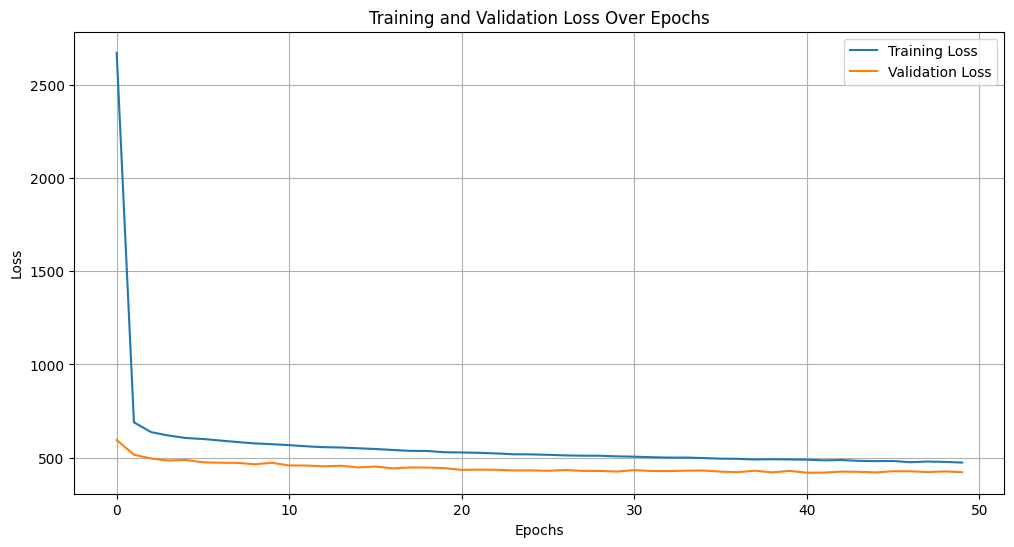

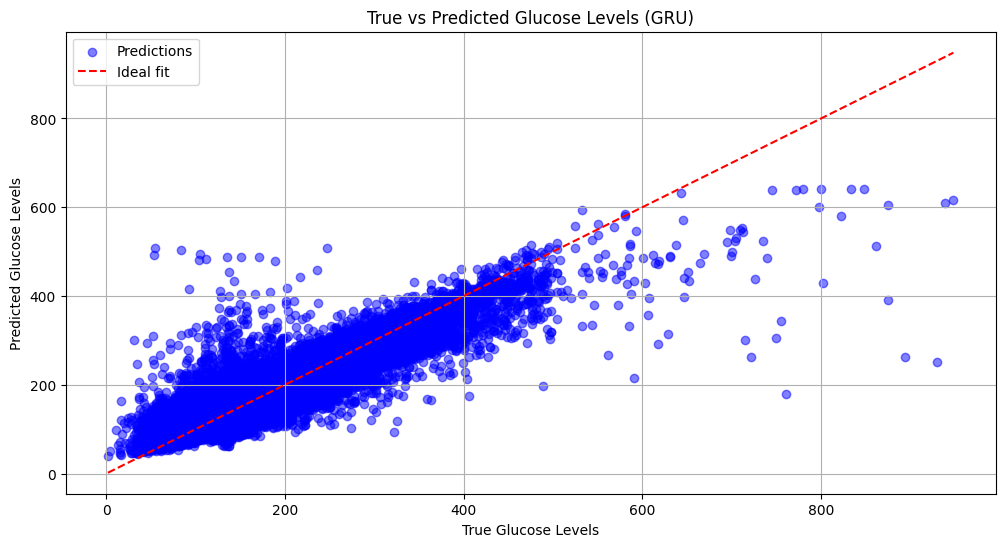

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Visualizing Results
plt.figure(figsize=(12, 6))
plt.scatter(y_test, gru_predictions, color='blue', alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('True Glucose Levels')
plt.ylabel('Predicted Glucose Levels')
plt.title('True vs Predicted Glucose Levels (GRU)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Drop the 'GLCTIMER' column as it's not used for prediction
df = df[['GLC', 'INPUT', 'INPUT_HRS']]

# Fill missing values
df = df.dropna()

# Normalize the data
scaler = StandardScaler()
df[['GLC', 'INPUT', 'INPUT_HRS']] = scaler.fit_transform(df[['GLC', 'INPUT', 'INPUT_HRS']])

# Create time series sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # GLC value at next time step
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the time series sequence

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Create sequences for training and testing, now without 'GLCTIMER'
X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# Define the LSTM model
model_lstm = Sequential([
    LSTM(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Use Adam as optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predictions
lstm_predictions = model_lstm.predict(X_test)

# Evaluation
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = mean_squared_error(y_test, lstm_predictions, squared=False)
r2_lstm = r2_score(y_test, lstm_predictions)
mape_lstm = mean_absolute_percentage_error(y_test, lstm_predictions)

print("=== Performance of the LSTM model ===")
print(f"Mean Absolute Error: {mae_lstm}")
print(f"Mean Squared Error: {mse_lstm}")
print(f"Root Mean Squared Error: {rmse_lstm}")
print(f"R-squared: {r2_lstm}")
print(f"Mean Absolute Percentage Error: {mape_lstm}")

Epoch 1/50
12075/12075 [==============================] - 164s 13ms/step - loss: 0.6700 - val_loss: 0.6192
Epoch 2/50
12075/12075 [==============================] - 161s 13ms/step - loss: 0.6496 - val_loss: 0.6087
Epoch 3/50
12075/12075 [==============================] - 158s 13ms/step - loss: 0.6403 - val_loss: 0.6055
Epoch 4/50
12075/12075 [==============================] - 155s 13ms/step - loss: 0.6312 - val_loss: 0.5993
Epoch 5/50
12075/12075 [==============================] - 168s 14ms/step - loss: 0.6274 - val_loss: 0.5951
Epoch 6/50
12075/12075 [==============================] - 171s 14ms/step - loss: 0.6245 - val_loss: 0.5962
Epoch 7/50
12075/12075 [==============================] - 162s 13ms/step - loss: 0.6210 - val_loss: 0.5936
Epoch 8/50
12075/12075 [==============================] - 168s 14ms/step - loss: 0.6177 - val_loss: 0.5911
Epoch 9/50
12075/12075 [==============================] - 163s 13ms/step - loss: 0.6136 - val_loss: 0.5922
Epoch 10/50
12075/12075 [============

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# Evaluation
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = mean_squared_error(y_test, lstm_predictions, squared=False)
r2_lstm = r2_score(y_test, lstm_predictions)
mape_lstm = mean_absolute_percentage_error(y_test, lstm_predictions)

print("=== Performance of the LSTM model ===")
print(f"Mean Absolute Error: {mae_lstm}")
print(f"Mean Squared Error: {mse_lstm}")
print(f"Root Mean Squared Error: {rmse_lstm}")
print(f"R-squared: {r2_lstm}")
print(f"Mean Absolute Percentage Error: {mape_lstm}")

=== Performance of the LSTM model ===
Mean Absolute Error: 0.5156640492583499
Mean Squared Error: 0.7234867769332524
Root Mean Squared Error: 0.8505802589604654
R-squared: 0.3313200763468227
Mean Absolute Percentage Error: 1.6707697192217617


In [ ]:
# Convertir les valeurs prédites et réelles en classes pour l'évaluation de la classification
hyper_threshold = 1.0  # Placeholder, ajustez selon vos besoins
hypo_threshold = -1.0  # Placeholder, ajustez selon vos besoins

y_test_class = np.where(y_test > hyper_threshold, 1, np.where(y_test < hypo_threshold, -1, 0))
lstm_predictions_class = np.where(lstm_predictions > hyper_threshold, 1, np.where(lstm_predictions < hypo_threshold, -1, 0))

# Évaluation des métriques de classification
accuracy = accuracy_score(y_test_class, lstm_predictions_class)
f1 = f1_score(y_test_class, lstm_predictions_class, average='weighted')
precision = precision_score(y_test_class, lstm_predictions_class, average='weighted')
recall = recall_score(y_test_class, lstm_predictions_class, average='weighted')
conf_matrix = confusion_matrix(y_test_class, lstm_predictions_class)

print("=== Classification Metrics ===")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

=== Classification Metrics ===
Accuracy: 0.8338785685298526
F1 Score: 0.7986687264036607
Precision: 0.8103706455387549
Recall: 0.8338785685298526
Confusion Matrix:
[[  943  7037    69]
 [  381 95816  2639]
 [   15  9917  3926]]


In [ ]:
# Différents taux d'apprentissage à essayer
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    # Définir le modèle LSTM
    model_lstm = Sequential([
        LSTM(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])

    # Utiliser Adam avec le taux d'apprentissage actuel
    optimizer = Adam(learning_rate=lr)

    # Compiler le modèle
    model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

    # Entraîner le modèle
    history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Évaluer le modèle sur l'ensemble de test
    mae_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)

    print(f"Learning Rate: {lr}, Mean Absolute Error: {mae_lstm}")
    # Evaluation



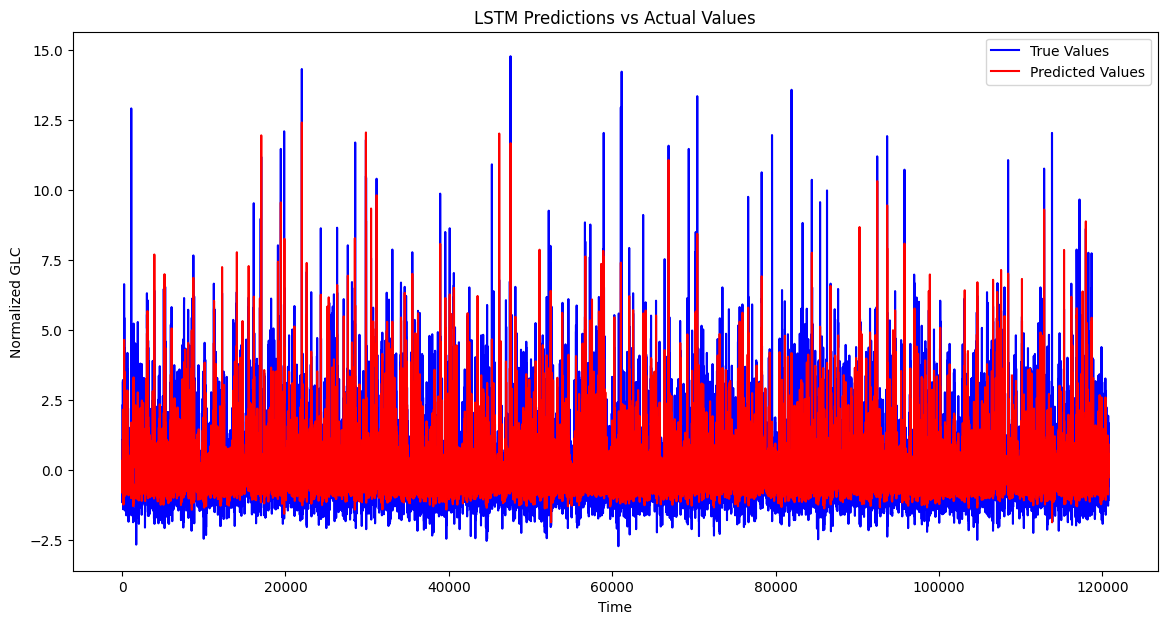

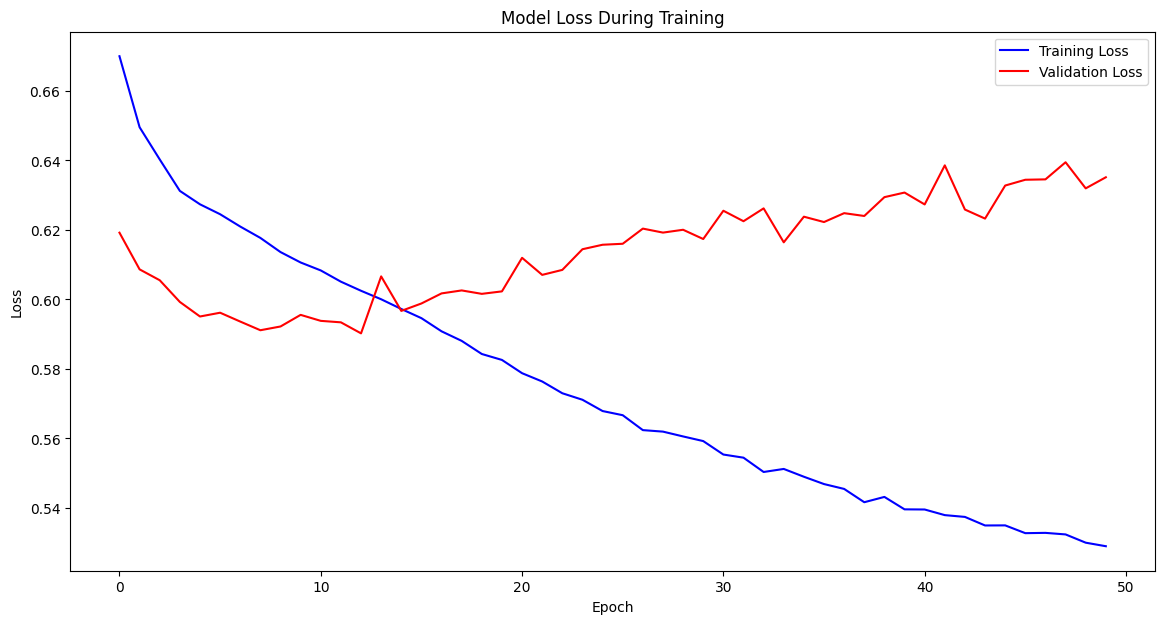

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(lstm_predictions, label='Predicted Values', color='red')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Normalized GLC')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Define the BRNN model
model_brnn = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

# Define the optimizer
# It's good practice to define the optimizer right before compiling the model
optimizer = Adam(learning_rate=0.001)  # Set your desired learning rate

# Compile the model
model_brnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history_brnn = model_brnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predictions
brnn_predictions = model_brnn.predict(X_test)

# Evaluation
mae_brnn = mean_absolute_error(y_test, brnn_predictions)
mse_brnn = mean_squared_error(y_test, brnn_predictions)
rmse_brnn = mean_squared_error(y_test, brnn_predictions, squared=False)
r2_brnn = r2_score(y_test, brnn_predictions)
mape_brnn = mean_absolute_percentage_error(y_test, brnn_predictions)

print("=== Performance of the Bidirectional LSTM model ===")
print(f"Mean Absolute Error: {mae_brnn}")
print(f"Mean Squared Error: {mse_brnn}")
print(f"Root Mean Squared Error: {rmse_brnn}")
print(f"R-squared: {r2_brnn}")
print(f"Mean Absolute Percentage Error: {mape_brnn}")

Epoch 1/50
12075/12075 [==============================] - 274s 22ms/step - loss: 0.6679 - val_loss: 0.6196
Epoch 2/50
12075/12075 [==============================] - 267s 22ms/step - loss: 0.6419 - val_loss: 0.6005
Epoch 3/50
12075/12075 [==============================] - 277s 23ms/step - loss: 0.6310 - val_loss: 0.5992
Epoch 4/50
12075/12075 [==============================] - 288s 24ms/step - loss: 0.6243 - val_loss: 0.5938
Epoch 5/50
12075/12075 [==============================] - 275s 23ms/step - loss: 0.6195 - val_loss: 0.5934
Epoch 6/50
12075/12075 [==============================] - 278s 23ms/step - loss: 0.6163 - val_loss: 0.5922
Epoch 7/50
12075/12075 [==============================] - 280s 23ms/step - loss: 0.6118 - val_loss: 0.5934
Epoch 8/50
12075/12075 [==============================] - 278s 23ms/step - loss: 0.6074 - val_loss: 0.5919
Epoch 9/50
12075/12075 [==============================] - 278s 23ms/step - loss: 0.6046 - val_loss: 0.5954
Epoch 10/50
12075/12075 [============

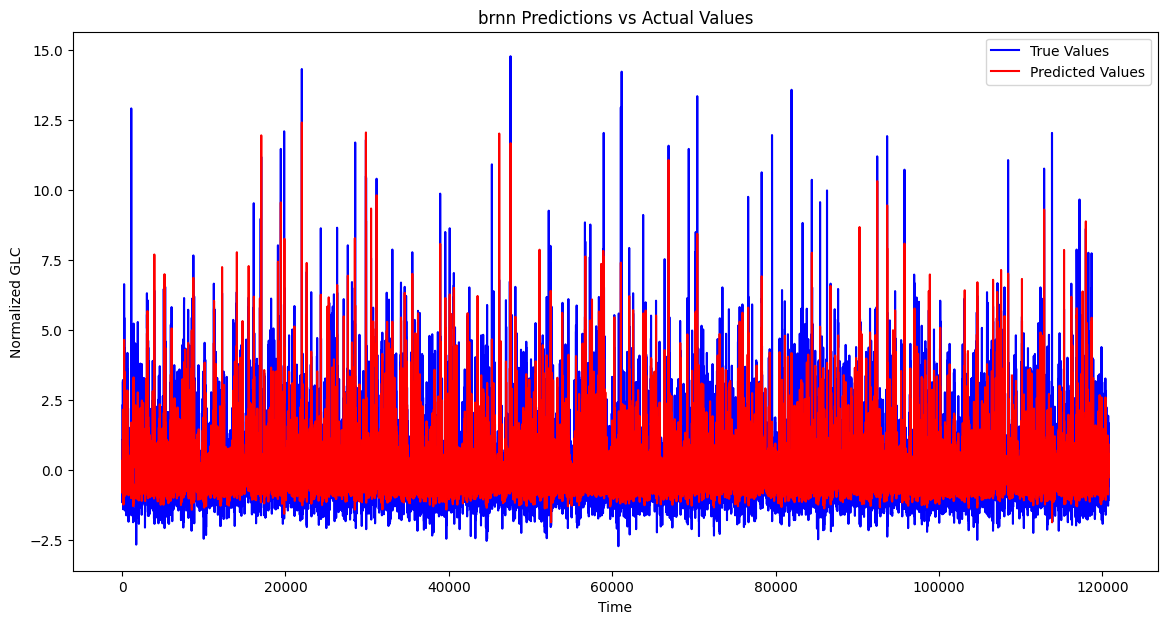

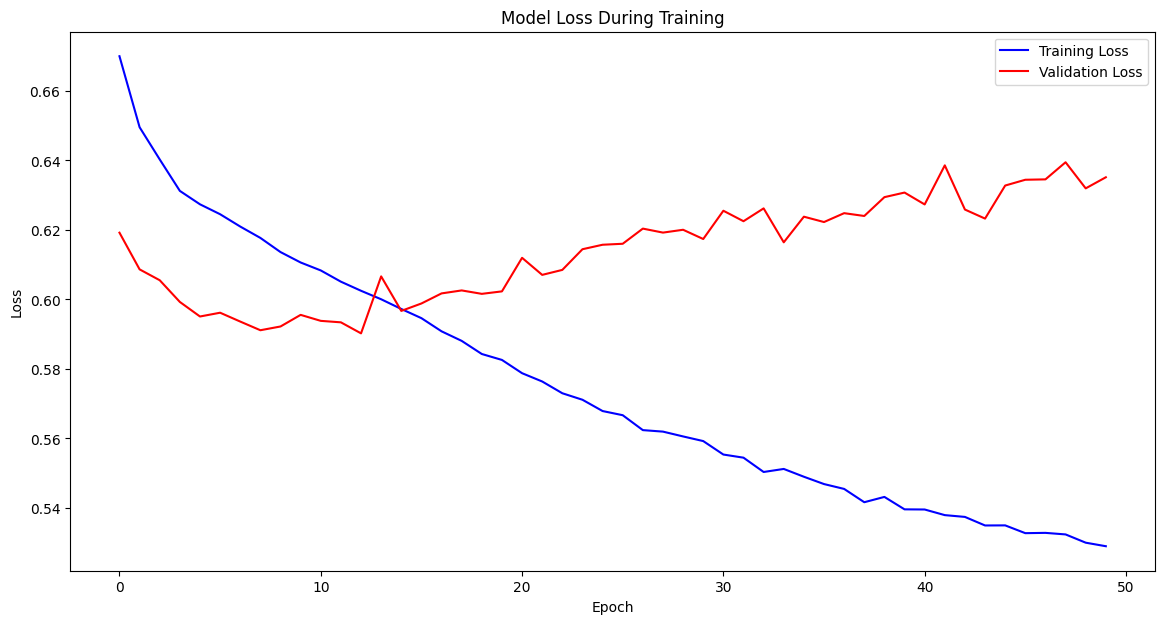

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(lstm_predictions, label='Predicted Values', color='red')
plt.title('brnn Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Normalized GLC')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Drop the 'GLCTIMER' column as it's not used for prediction
df = df[['GLC', 'INPUT', 'INPUT_HRS']]

# Fill missing values
df = df.dropna()

# Normalize the data
scaler = StandardScaler()
df[['GLC', 'INPUT', 'INPUT_HRS']] = scaler.fit_transform(df[['GLC', 'INPUT', 'INPUT_HRS']])

# Create time series sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # GLC value at next time step
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the time series sequence

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Create sequences for training and testing, now without 'GLCTIMER'
X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# Reshape data for Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Define and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

# Predictions using Random Forest model
rf_predictions = rf_model.predict(X_test_rf)

# Evaluation for Random Forest
mae_rf = mean_absolute_error(y_test, rf_predictions)
mse_rf = mean_squared_error(y_test, rf_predictions)
rmse_rf = mean_squared_error(y_test, rf_predictions, squared=False)
r2_rf = r2_score(y_test, rf_predictions)
mape_rf = mean_absolute_percentage_error(y_test, rf_predictions)

print("=== Performance of the Random Forest model ===")
print(f"Mean Absolute Error: {mae_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"R-squared: {r2_rf}")
print(f"Mean Absolute Percentage Error: {mape_rf}")


=== Performance of the Random Forest model ===
Mean Absolute Error: 0.5253819882098196
Mean Squared Error: 0.6886876475476339
Root Mean Squared Error: 0.8298720669763707
R-squared: 0.36348304037417933
Mean Absolute Percentage Error: 1.7690664362041033


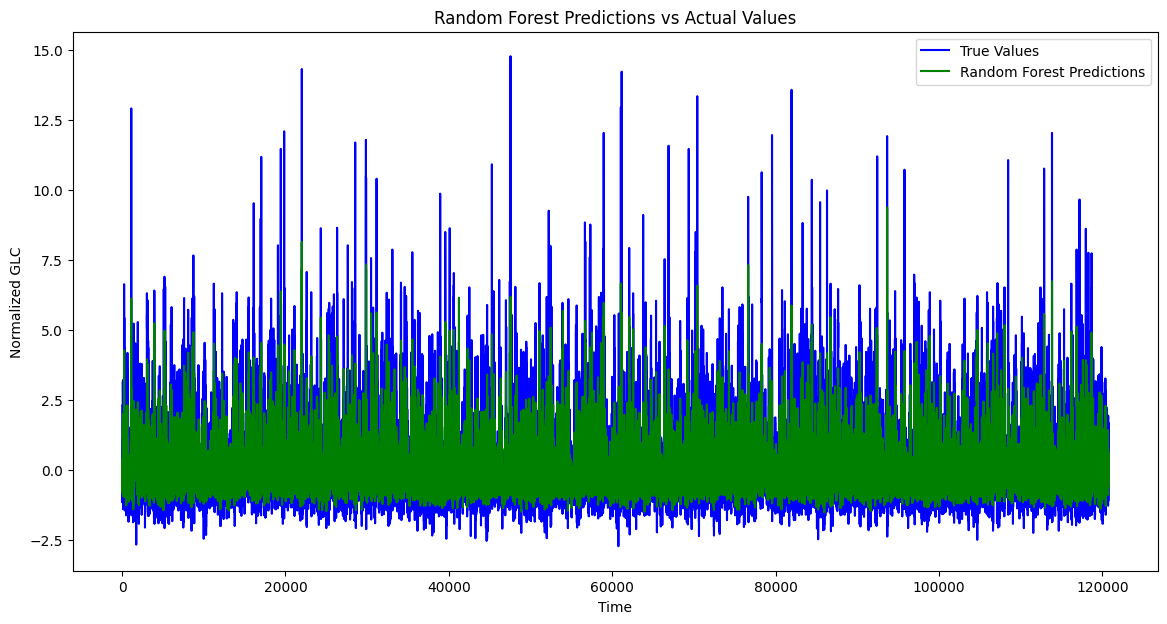

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values for Random Forest
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(rf_predictions, label='Random Forest Predictions', color='green')
plt.title('Random Forest Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Normalized GLC')
plt.legend()
plt.show()




=== Performance of the Random Forest model ===
Accuracy: 0.624831253157533
Classification Report:
                        precision    recall  f1-score   support

   Severe Hypoglycemia       0.34      0.12      0.18     28620
 Moderate Hypoglycemia       0.01      0.00      0.00      1222
                Normal       0.67      0.91      0.77     77108
Moderate Hyperglycemia       0.34      0.13      0.19     13386
  Severe Hyperglycemia       0.02      0.00      0.00       407

              accuracy                           0.62    120743
             macro avg       0.28      0.23      0.23    120743
          weighted avg       0.54      0.62      0.55    120743

Confusion Matrix:
[[ 3488    18 23804  1294    16]
 [   63     1  1128    30     0]
 [ 4808    50 70244  1985    21]
 [ 1848     8  9812  1710     8]
 [   23     1   369    13     1]]


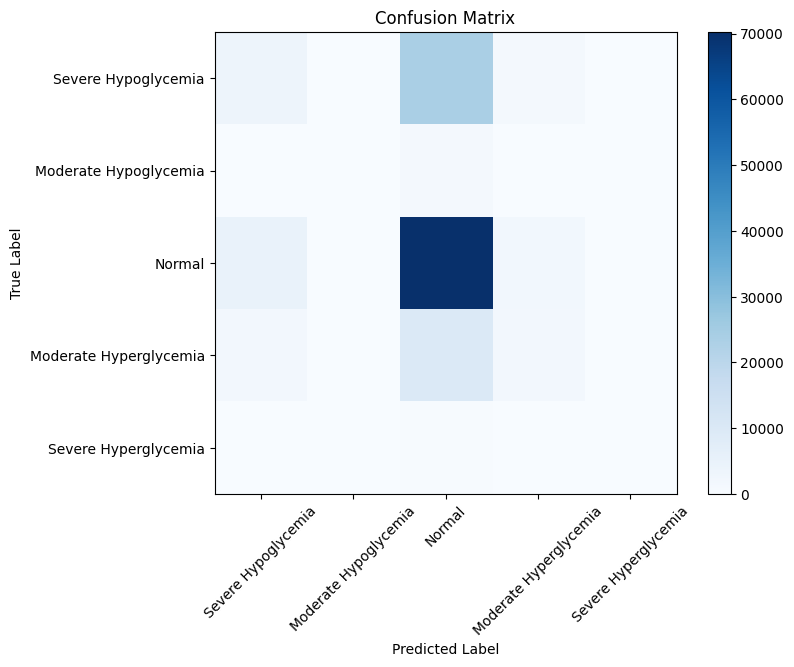

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

class GlucosePredictor:
    def __init__(self, data_path, sequence_length=10):
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.rf_model = None
        self.scaler = StandardScaler()
        self.classes = ['Severe Hypoglycemia', 'Moderate Hypoglycemia', 'Normal', 'Moderate Hyperglycemia', 'Severe Hyperglycemia']

    def load_data(self):
        # Load the data
        self.df = pd.read_csv(self.data_path)

        # Convert time columns to datetime
        self.df['TIMER'] = pd.to_datetime(self.df['TIMER'])
        self.df['STARTTIME'] = pd.to_datetime(self.df['STARTTIME'])
        self.df['ENDTIME'] = pd.to_datetime(self.df['ENDTIME'])
        self.df['GLCTIMER'] = pd.to_datetime(self.df['GLCTIMER'])

        # Drop the 'GLCTIMER' column as it's not used for prediction
        self.df = self.df[['GLC', 'INPUT', 'INPUT_HRS']]

        # Fill missing values
        self.df = self.df.dropna()

        # Categorize glucose levels into classes
        bins = [-np.inf, 54, 70, 140, 200, np.inf]
        labels = self.classes
        self.df['GLC_Class'] = pd.cut(self.df['GLC'], bins=bins, labels=labels)

        # Normalize the data
        self.df[['INPUT', 'INPUT_HRS']] = self.scaler.fit_transform(self.df[['INPUT', 'INPUT_HRS']])

    def create_sequences(self, data, target):
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i+self.sequence_length])
            y.append(target[i+self.sequence_length])
        return np.array(X), np.array(y)

    def split_data(self, test_size=0.2):
        # Split data into training and testing sets
        X = self.df[['INPUT', 'INPUT_HRS']].values
        y = self.df['GLC_Class'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

        # Create sequences for training and testing
        self.X_train, self.y_train = self.create_sequences(X_train, y_train)
        self.X_test, self.y_test = self.create_sequences(X_test, y_test)

    def train_random_forest(self, n_estimators=100):
        # Reshape data for Random Forest
        X_train_rf = self.X_train.reshape(self.X_train.shape[0], -1)
        X_test_rf = self.X_test.reshape(self.X_test.shape[0], -1)

        # Define and train Random Forest model
        self.rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        self.rf_model.fit(X_train_rf, self.y_train)

    def evaluate(self):
        # Predictions using Random Forest model
        rf_predictions = self.rf_model.predict(self.X_test.reshape(self.X_test.shape[0], -1))

        # Evaluation for Random Forest
        accuracy = accuracy_score(self.y_test, rf_predictions)
        report = classification_report(self.y_test, rf_predictions, target_names=self.classes)
        confusion_mat = confusion_matrix(self.y_test, rf_predictions)

        print("=== Performance of the Random Forest model ===")
        print(f"Accuracy: {accuracy}")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        print(confusion_mat)

    def plot_confusion_matrix(self):
        # Plot confusion matrix
        confusion_mat = confusion_matrix(self.y_test, self.rf_model.predict(self.X_test.reshape(self.X_test.shape[0], -1)))
        plt.figure(figsize=(8, 6))
        plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# Initialize GlucosePredictor
predictor = GlucosePredictor(data_path="/content/drive/My Drive/INC_cleaned.csv")

# Load data
predictor.load_data()

# Split data
predictor.split_data()

# Train Random Forest model
predictor.train_random_forest()

# Evaluate
predictor.evaluate()

# Plot confusion matrix
predictor.plot_confusion_matrix()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Drop the 'GLCTIMER' column as it's not used for prediction
df = df[['GLC', 'INPUT', 'INPUT_HRS']]

# Fill missing values
df = df.dropna()

# Normalize the data
scaler = StandardScaler()
df[['GLC', 'INPUT', 'INPUT_HRS']] = scaler.fit_transform(df[['GLC', 'INPUT', 'INPUT_HRS']])

# Create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # GLC value at next time step
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the time series sequence

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# Define GRU model
gru_model = Sequential([
    GRU(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predictions using GRU model
gru_predictions = gru_model.predict(X_test)

# Evaluation for GRU
mse = mean_squared_error(y_test, gru_predictions)
mae = mean_absolute_error(y_test, gru_predictions)
mape = mean_absolute_percentage_error(y_test, gru_predictions)
r2 = r2_score(y_test, gru_predictions)

print("=== Performance of the GRU model ===")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R-squared: {r2}")

# Convert continuous predictions to classes
def convert_to_classes(values):
    # Adjust the bin edges to cover the range of normalized GLC values
    bins = [-np.inf, -1.5, -1, 0.5, 1.5, np.inf]  # Example bin edges, adjust as needed
    return np.digitize(values, bins) - 1

y_test_classes = convert_to_classes(y_test)
gru_predictions_classes = convert_to_classes(gru_predictions.flatten())

# Calculate accuracy, classification report and confusion matrix
accuracy = accuracy_score(y_test_classes, gru_predictions_classes)
report = classification_report(y_test_classes, gru_predictions_classes, target_names=['Severe Hypoglycemia', 'Moderate Hypoglycemia', 'Normal', 'Moderate Hyperglycemia', 'Severe Hyperglycemia'])
confusion_mat = confusion_matrix(y_test_classes, gru_predictions_classes)

print("=== Classification Performance of the GRU model ===")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(confusion_mat)

Epoch 1/50
12075/12075 [==============================] - 143s 12ms/step - loss: 0.6732 - val_loss: 0.6271
Epoch 2/50
12075/12075 [==============================] - 139s 12ms/step - loss: 0.6533 - val_loss: 0.6185
Epoch 3/50
12075/12075 [==============================] - 136s 11ms/step - loss: 0.6429 - val_loss: 0.6061
Epoch 4/50
12075/12075 [==============================] - 142s 12ms/step - loss: 0.6361 - val_loss: 0.6070
Epoch 5/50
12075/12075 [==============================] - 138s 11ms/step - loss: 0.6319 - val_loss: 0.5999
Epoch 6/50
12075/12075 [==============================] - 138s 11ms/step - loss: 0.6282 - val_loss: 0.5965
Epoch 7/50
12075/12075 [==============================] - 136s 11ms/step - loss: 0.6261 - val_loss: 0.5940
Epoch 8/50
12075/12075 [==============================] - 138s 11ms/step - loss: 0.6233 - val_loss: 0.5914
Epoch 9/50
12075/12075 [==============================] - 139s 12ms/step - loss: 0.6208 - val_loss: 0.5917
Epoch 10/50
12075/12075 [============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3774/3774 [==============================] - 22s 6ms/step
=== Performance of the GRU model ===
Mean Squared Error: 0.6882245493316819
Mean Absolute Error: 0.5192266107083764
Mean Absolute Percentage Error: 1.7484849672848186
R-squared: 0.36391105715286776


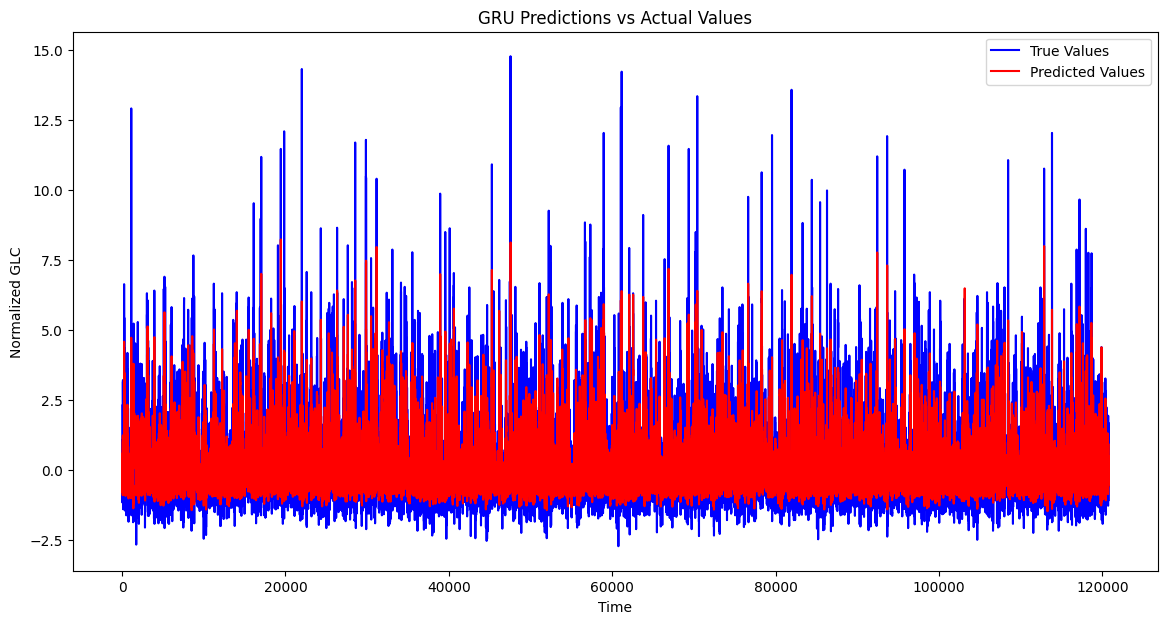

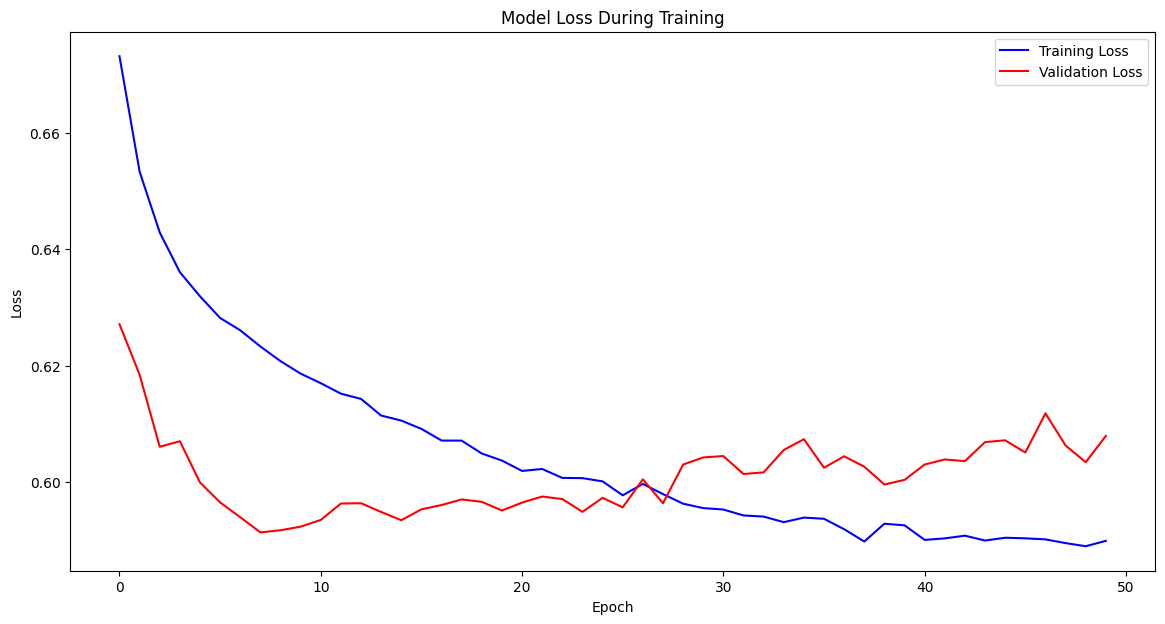

In [ ]:
# Assume `gru_model`, `X_test`, and `y_test` are already defined from the previous training process

# Predictions using GRU model
gru_predictions = gru_model.predict(X_test)

# Evaluation for GRU
mse = mean_squared_error(y_test, gru_predictions)
mae = mean_absolute_error(y_test, gru_predictions)
mape = mean_absolute_percentage_error(y_test, gru_predictions)
r2 = r2_score(y_test, gru_predictions)

print("=== Performance of the GRU model ===")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R-squared: {r2}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(gru_predictions, label='Predicted Values', color='red')
plt.title('GRU Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Normalized GLC')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


=== Performance du modèle de Régression Polynomiale ===
Sur l'ensemble d'entraînement :
Mean Absolute Error: 18.67050545058848
Mean Squared Error: 923.6816696792165
Root Mean Squared Error: 30.392131706729895
R-squared: 0.6663522770272505
Mean Absolute Percentage Error: 0.12994369671264322

Sur l'ensemble de test :
Mean Absolute Error: 18.540357168146578
Mean Squared Error: 900.2990365638785
Root Mean Squared Error: 30.00498352880532
R-squared: 0.6748392326087221
Mean Absolute Percentage Error: 0.12703465435176733


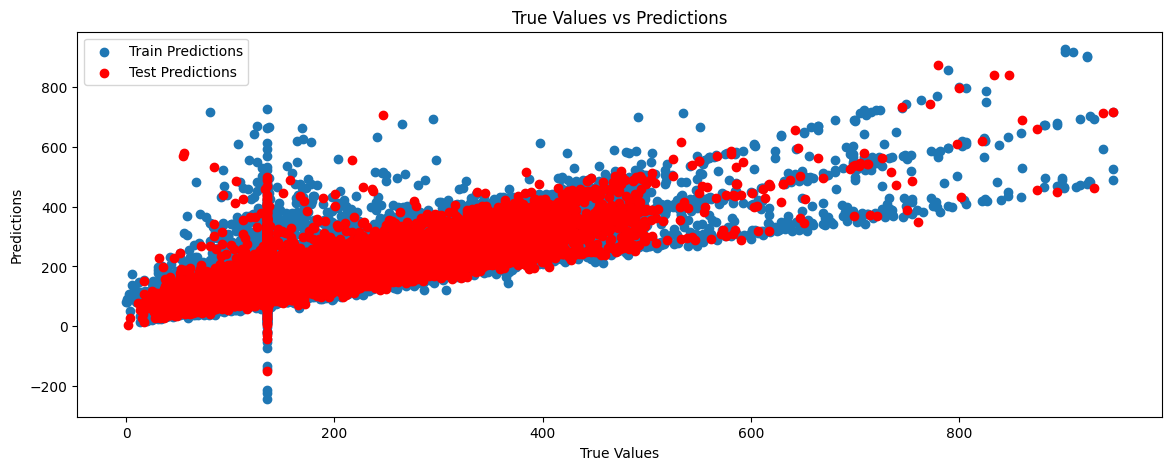

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Calculate time difference in minutes between GLCTIMER and STARTTIME
df['time_diff'] = (df['GLCTIMER'] - df['STARTTIME']).dt.total_seconds() / 60.0

# Drop rows with NaN values in 'time_diff'
df = df.dropna(subset=['time_diff'])

# Feature engineering
df['INPUT_length'] = df['INPUT'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df['hour_of_day'] = df['GLCTIMER'].dt.hour
df['day_of_week'] = df['GLCTIMER'].dt.dayofweek
df['rolling_mean'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_std'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

# Selecting important features for prediction
features = df[['time_diff', 'INPUT', 'INPUT_HRS', 'hour_of_day', 'day_of_week', 'rolling_mean', 'rolling_std']]
labels = df['GLC']

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Polynomial regression
degree = 2  # Degré du polynôme
poly_features = PolynomialFeatures(degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)

# Predictions de la régression polynomiale
poly_train_predictions = polyreg.predict(X_train_poly)
poly_test_predictions = polyreg.predict(X_test_poly)

# Mesures de performance de la régression polynomiale
mae_poly_train = mean_absolute_error(y_train, poly_train_predictions)
mae_poly_test = mean_absolute_error(y_test, poly_test_predictions)
mse_poly_train = mean_squared_error(y_train, poly_train_predictions)
mse_poly_test = mean_squared_error(y_test, poly_test_predictions)
rmse_poly_train = mean_squared_error(y_train, poly_train_predictions, squared=False)
rmse_poly_test = mean_squared_error(y_test, poly_test_predictions, squared=False)
r2_poly_train = r2_score(y_train, poly_train_predictions)
r2_poly_test = r2_score(y_test, poly_test_predictions)
mape_poly_train = mean_absolute_percentage_error(y_train, poly_train_predictions)
mape_poly_test = mean_absolute_percentage_error(y_test, poly_test_predictions)

print("=== Performance du modèle de Régression Polynomiale ===")
print("Sur l'ensemble d'entraînement :")
print(f"Mean Absolute Error: {mae_poly_train}")
print(f"Mean Squared Error: {mse_poly_train}")
print(f"Root Mean Squared Error: {rmse_poly_train}")
print(f"R-squared: {r2_poly_train}")
print(f"Mean Absolute Percentage Error: {mape_poly_train}")
print("\nSur l'ensemble de test :")
print(f"Mean Absolute Error: {mae_poly_test}")
print(f"Mean Squared Error: {mse_poly_test}")
print(f"Root Mean Squared Error: {rmse_poly_test}")
print(f"R-squared: {r2_poly_test}")
print(f"Mean Absolute Percentage Error: {mape_poly_test}")

# Tracer les graphiques d'apprentissage
plt.figure(figsize=(14, 5))

# Graphique des valeurs prédites vs réelles
plt.scatter(y_train, poly_train_predictions, label='Train Predictions')
plt.scatter(y_test, poly_test_predictions, color='red', label='Test Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()


=== Performance du modèle de Régression Polynomiale ===
Sur l'ensemble d'entraînement :
Mean Absolute Error: 18.67050545058848
Mean Squared Error: 923.6816696792165
Root Mean Squared Error: 30.392131706729895
R-squared: 0.6663522770272505
Mean Absolute Percentage Error: 0.12994369671264322

Sur l'ensemble de test :
Mean Absolute Error: 18.540357168146578
Mean Squared Error: 900.2990365638785
Root Mean Squared Error: 30.00498352880532
R-squared: 0.6748392326087221
Mean Absolute Percentage Error: 0.12703465435176733


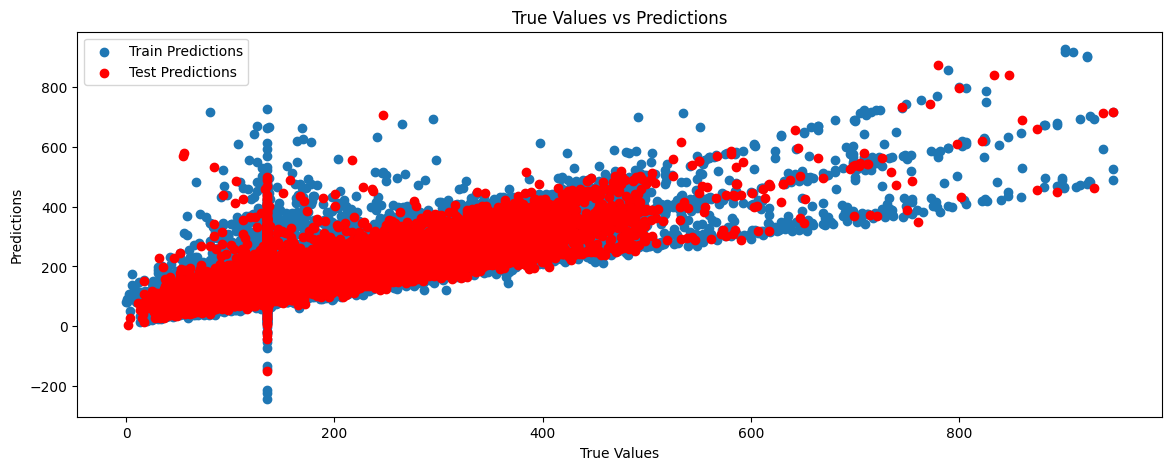

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Calculate time difference in minutes between GLCTIMER and STARTTIME
df['time_diff'] = (df['GLCTIMER'] - df['STARTTIME']).dt.total_seconds() / 60.0

# Drop rows with NaN values in 'time_diff'
df = df.dropna(subset=['time_diff'])

# Feature engineering
df['INPUT_length'] = df['INPUT'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df['hour_of_day'] = df['GLCTIMER'].dt.hour
df['day_of_week'] = df['GLCTIMER'].dt.dayofweek
df['rolling_mean'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_std'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

# Selecting important features for prediction
features = df[['time_diff', 'INPUT', 'INPUT_HRS', 'hour_of_day', 'day_of_week', 'rolling_mean', 'rolling_std']]
labels = df['GLC']

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Polynomial regression
degree = 2  # Degré du polynôme
poly_features = PolynomialFeatures(degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)

# Predictions de la régression polynomiale
poly_train_predictions = polyreg.predict(X_train_poly)
poly_test_predictions = polyreg.predict(X_test_poly)

# Mesures de performance de la régression polynomiale
mae_poly_train = mean_absolute_error(y_train, poly_train_predictions)
mae_poly_test = mean_absolute_error(y_test, poly_test_predictions)
mse_poly_train = mean_squared_error(y_train, poly_train_predictions)
mse_poly_test = mean_squared_error(y_test, poly_test_predictions)
rmse_poly_train = mean_squared_error(y_train, poly_train_predictions, squared=False)
rmse_poly_test = mean_squared_error(y_test, poly_test_predictions, squared=False)
r2_poly_train = r2_score(y_train, poly_train_predictions)
r2_poly_test = r2_score(y_test, poly_test_predictions)
mape_poly_train = mean_absolute_percentage_error(y_train, poly_train_predictions)
mape_poly_test = mean_absolute_percentage_error(y_test, poly_test_predictions)

print("=== Performance du modèle de Régression Polynomiale ===")
print("Sur l'ensemble d'entraînement :")
print(f"Mean Absolute Error: {mae_poly_train}")
print(f"Mean Squared Error: {mse_poly_train}")
print(f"Root Mean Squared Error: {rmse_poly_train}")
print(f"R-squared: {r2_poly_train}")
print(f"Mean Absolute Percentage Error: {mape_poly_train}")
print("\nSur l'ensemble de test :")
print(f"Mean Absolute Error: {mae_poly_test}")
print(f"Mean Squared Error: {mse_poly_test}")
print(f"Root Mean Squared Error: {rmse_poly_test}")
print(f"R-squared: {r2_poly_test}")
print(f"Mean Absolute Percentage Error: {mape_poly_test}")

# Tracer les graphiques d'apprentissage
plt.figure(figsize=(14, 5))

# Graphique des valeurs prédites vs réelles
plt.scatter(y_train, poly_train_predictions, label='Train Predictions')
plt.scatter(y_test, poly_test_predictions, color='red', label='Test Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()



=== Performance du modèle K-Nearest Neighbors ===
Sur l'ensemble d'entraînement :
Mean Absolute Error: 9.93403239346516
Mean Squared Error: 440.2643531939772
Root Mean Squared Error: 20.982477289252028
R-squared: 0.8409698884679013
Mean Absolute Percentage Error: 0.07271017024527118

Sur l'ensemble de test :
Mean Absolute Error: 12.173561236573834
Mean Squared Error: 637.4594705953474
Root Mean Squared Error: 25.247959731339627
R-squared: 0.7697689298538819
Mean Absolute Percentage Error: 0.08709464835744726


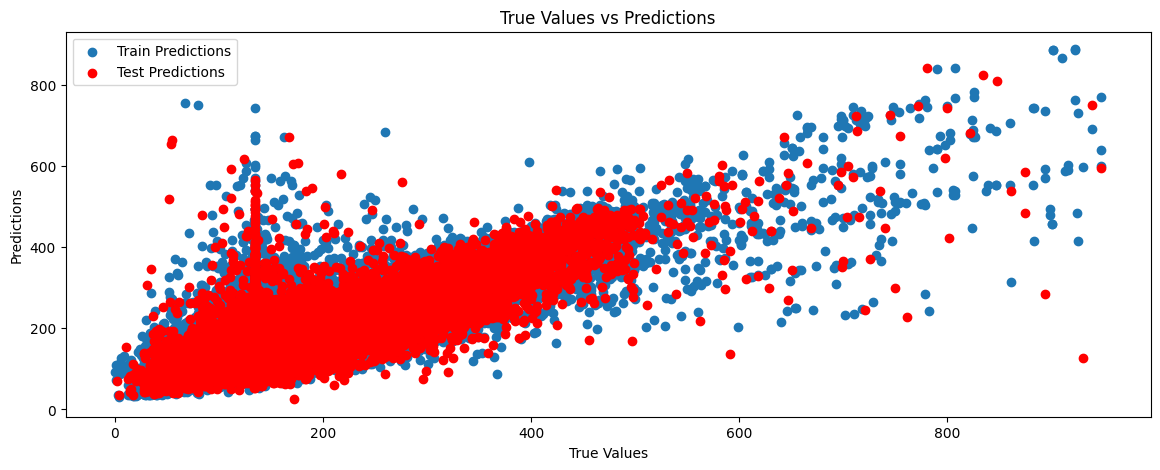

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Calculate time difference in minutes between GLCTIMER and STARTTIME
df['time_diff'] = (df['GLCTIMER'] - df['STARTTIME']).dt.total_seconds() / 60.0

# Drop rows with NaN values in 'time_diff'
df = df.dropna(subset=['time_diff'])

# Feature engineering
df['INPUT_length'] = df['INPUT'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df['hour_of_day'] = df['GLCTIMER'].dt.hour
df['day_of_week'] = df['GLCTIMER'].dt.dayofweek
df['rolling_mean'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_std'] = df.groupby('SUBJECT_ID')['GLC'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

# Selecting important features for prediction
features = df[['time_diff', 'INPUT', 'INPUT_HRS', 'hour_of_day', 'day_of_week', 'rolling_mean', 'rolling_std']]
labels = df['GLC']

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# K-Nearest Neighbors regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions du modèle KNN
knn_train_predictions = knn.predict(X_train)
knn_test_predictions = knn.predict(X_test)

# Mesures de performance du modèle KNN
mae_knn_train = mean_absolute_error(y_train, knn_train_predictions)
mae_knn_test = mean_absolute_error(y_test, knn_test_predictions)
mse_knn_train = mean_squared_error(y_train, knn_train_predictions)
mse_knn_test = mean_squared_error(y_test, knn_test_predictions)
rmse_knn_train = mean_squared_error(y_train, knn_train_predictions, squared=False)
rmse_knn_test = mean_squared_error(y_test, knn_test_predictions, squared=False)
r2_knn_train = r2_score(y_train, knn_train_predictions)
r2_knn_test = r2_score(y_test, knn_test_predictions)
mape_knn_train = mean_absolute_percentage_error(y_train, knn_train_predictions)
mape_knn_test = mean_absolute_percentage_error(y_test, knn_test_predictions)

print("=== Performance du modèle K-Nearest Neighbors ===")
print("Sur l'ensemble d'entraînement :")
print(f"Mean Absolute Error: {mae_knn_train}")
print(f"Mean Squared Error: {mse_knn_train}")
print(f"Root Mean Squared Error: {rmse_knn_train}")
print(f"R-squared: {r2_knn_train}")
print(f"Mean Absolute Percentage Error: {mape_knn_train}")
print("\nSur l'ensemble de test :")
print(f"Mean Absolute Error: {mae_knn_test}")
print(f"Mean Squared Error: {mse_knn_test}")
print(f"Root Mean Squared Error: {rmse_knn_test}")
print(f"R-squared: {r2_knn_test}")
print(f"Mean Absolute Percentage Error: {mape_knn_test}")

# Tracer les graphiques d'apprentissage
plt.figure(figsize=(14, 5))

# Graphique des valeurs prédites vs réelles
plt.scatter(y_train, knn_train_predictions, label='Train Predictions')
plt.scatter(y_test, knn_test_predictions, color='red', label='Test Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()



=== Performance du modèle XGBoost ===
Sur l'ensemble d'entraînement :
Accuracy: 0.9212088337532686

Sur l'ensemble de test :
Accuracy: 0.9202421471930304

Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      1212
      Medium       0.92      1.00      0.96    111122
        High       0.00      0.00      0.00      8419

    accuracy                           0.92    120753
   macro avg       0.31      0.33      0.32    120753
weighted avg       0.85      0.92      0.88    120753



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


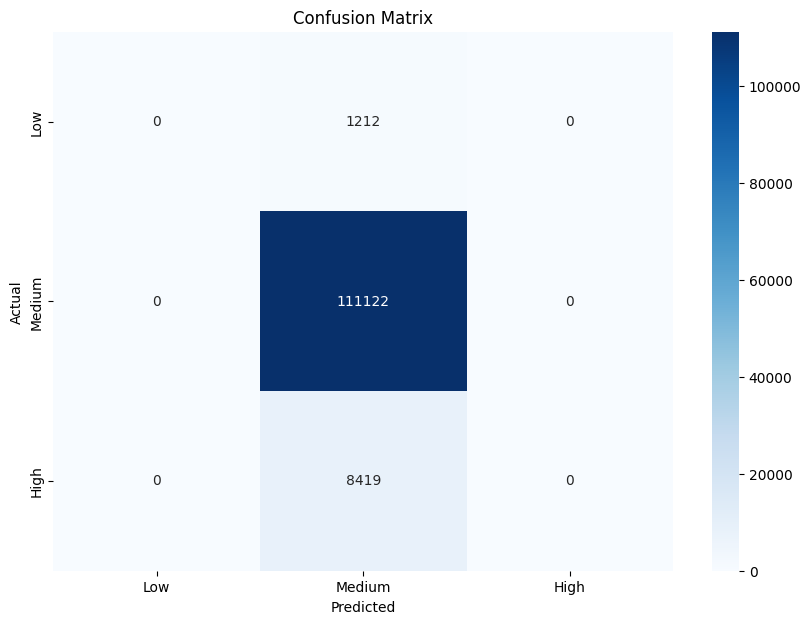

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = "/content/drive/My Drive/INC_cleaned.csv"
df = pd.read_csv(data_path)

# Convert time columns to datetime
df['TIMER'] = pd.to_datetime(df['TIMER'])
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'])
df['GLCTIMER'] = pd.to_datetime(df['GLCTIMER'])

# Drop the 'GLCTIMER' column as it's not used for prediction
df = df[['GLC', 'INPUT', 'INPUT_HRS']]

# Fill missing values
df = df.dropna()

# Normalize the data
scaler = StandardScaler()
df[['GLC', 'INPUT', 'INPUT_HRS']] = scaler.fit_transform(df[['GLC', 'INPUT', 'INPUT_HRS']])

# Convert continuous GLC to classes
def convert_to_classes(values):
    # Adjust the bin edges to create three classes: Low, Medium, High
    bins = [-np.inf, -1.5, 1.5, np.inf]
    return np.digitize(values, bins) - 1

df['GLC_class'] = convert_to_classes(df['GLC'])

# Selecting important features for prediction
features = df[['INPUT', 'INPUT_HRS']]
labels = df['GLC_class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Predictions du modèle XGBoost
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# Mesures de performance du modèle XGBoost
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== Performance du modèle XGBoost ===")
print("Sur l'ensemble d'entraînement :")
print(f"Accuracy: {train_accuracy}")
print("\nSur l'ensemble de test :")
print(f"Accuracy: {test_accuracy}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Low', 'Medium', 'High']))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Charger les données
# Charger les données
data_path = "/content/drive/My Drive/INC_cleaned.csv"
data = pd.read_csv(data_path)

# Conversion des dates et tri par temps
data['TIMER'] = pd.to_datetime(data['TIMER'])
data.sort_values(by=['SUBJECT_ID', 'TIMER'], inplace=True)

# Remplir les valeurs manquantes de 'INPUT_HRS' avec 0
data['INPUT_HRS'].fillna(0, inplace=True)

# Supprimer les lignes avec des valeurs manquantes dans 'INPUT', 'GLC', 'GLCSOURCE', et 'INSULINTYPE'
data = data.dropna(subset=['INPUT', 'GLC', 'GLCSOURCE', 'INSULINTYPE', 'EVENT'])

# Encoder les variables catégorielles
data = pd.get_dummies(data, columns=['INSULINTYPE', 'EVENT', 'GLCSOURCE'])
# Convert 'STARTTIME' to datetime
data['STARTTIME'] = pd.to_datetime(data['STARTTIME'])

# Calculate time difference
data['TIME_DIFF'] = (data['TIMER'] - data['STARTTIME']).dt.total_seconds() / 3600.0



# Supprimer les lignes avec des valeurs manquantes dans les nouvelles fonctionnalités
data = data.dropna(subset=['TIME_DIFF'])

# Sélection des features et de la cible
features = ['INPUT', 'INPUT_HRS', 'LOS_ICU_days', 'TIME_DIFF',
            'INSULINTYPE_Intermediate', 'INSULINTYPE_Long', 'INSULINTYPE_Short',
            'EVENT_BOLUS_INYECTION', 'EVENT_BOLUS_PUSH', 'EVENT_INFUSION',
            'GLCSOURCE_BLOOD', 'GLCSOURCE_FINGERSTICK']

# Séparer les features et la cible
X = data[features]
y = data['GLC']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec GridSearchCV pour l'optimisation des hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

# Entraîner le modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_

# Faire des prédictions
y_pred = best_model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Erreur quadratique moyenne: {mse}')

# Afficher les prédictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())


Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
# Convert 'STARTTIME' to datetime
data['STARTTIME'] = pd.to_datetime(data['STARTTIME'])

# Calculate time difference
data['TIME_DIFF'] = (data['TIMER'] - data['STARTTIME']).dt.total_seconds() / 3600.0